Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.

This version of the model is designed with a convolutional model.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math
import numpy

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    plaform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 32
epochs = 500
learning_rate = 1e-4

#code_size = 100
code_sides = [16]

#image_count = 500
image_count = -1

## Dataset

ImageFolder is used to load the base distribution images

In [4]:
from torchvision.datasets import ImageFolder

from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
     torchvision.transforms.Grayscale(),
     torchvision.transforms.Resize((height,width)),
     torchvision.transforms.ToTensor(),
     #torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images"
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, shuffle=True
)

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

In this version, our autoencoder is intentionally split into two parts so that the encoder and decoder can be used separately. This version of the code uses a convolutional model.

In [5]:
class SplitAutoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            nn.Flatten(), # 131072x1
            nn.Linear(in_features=32*32*128,out_features=kwargs["code_size"]),
            nn.ReLU()
        )
        # result (encoding) is code_size x 1
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=kwargs["code_size"], out_features=32*32*128), #131072x1
            nn.Unflatten(1,(128,32,32)), # 32x32x128
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.Sigmoid(),
            nn.Upsample(scale_factor=2, mode='bilinear'), #256x256x1
            #nn.Sigmoid()
        )
        
    def forward(self, features):
        code = self.encoder(features)
        out = self.decoder(code)
        return out

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate our modules.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

models = []
optimizers = []

for i in range(len(code_sides)):
    code_size = code_sides[i] * code_sides[i]
    models.append(SplitAutoencoder(input_shape=image_size,code_size=code_size).to(device))
    optimizers.append(optim.Adam(models[i].parameters(), lr=learning_rate))

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

We train our autoencoder for our specified number of epochs.

In [7]:
for i in range(len(code_sides)):
    print("==================")
    print("Running for code size:" + str(code_sides[i] * code_sides[i]))
    for epoch in range(epochs):
        loss = 0
        for batch_features, labels in train_loader:
            # load it to the active device
            batch_features = batch_features.to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizers[i].zero_grad()

            # compute reconstructions
            codes = models[i].encoder(batch_features)
            outputs = models[i].decoder(codes)

            # compute training reconstruction loss
            train_loss = criterion(outputs,batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizers[i].step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(train_loader)

        # display the epoch training loss
        print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    

Running for code size:256


C:\Users\user\miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


epoch : 1/500, recon loss = 0.01731534
epoch : 2/500, recon loss = 0.00824000
epoch : 3/500, recon loss = 0.00689600
epoch : 4/500, recon loss = 0.00630832
epoch : 5/500, recon loss = 0.00605438
epoch : 6/500, recon loss = 0.00577280
epoch : 7/500, recon loss = 0.00524746
epoch : 8/500, recon loss = 0.00517877
epoch : 9/500, recon loss = 0.00487699
epoch : 10/500, recon loss = 0.00491920
epoch : 11/500, recon loss = 0.00452869
epoch : 12/500, recon loss = 0.00437507
epoch : 13/500, recon loss = 0.00427266
epoch : 14/500, recon loss = 0.00414506
epoch : 15/500, recon loss = 0.00400843
epoch : 16/500, recon loss = 0.00387741
epoch : 17/500, recon loss = 0.00376341
epoch : 18/500, recon loss = 0.00394951
epoch : 19/500, recon loss = 0.00360844
epoch : 20/500, recon loss = 0.00351142
epoch : 21/500, recon loss = 0.00349322
epoch : 22/500, recon loss = 0.00338074
epoch : 23/500, recon loss = 0.00333384
epoch : 24/500, recon loss = 0.00334719
epoch : 25/500, recon loss = 0.00322411
epoch : 2

And save the trained models

In [8]:
for i in range(len(code_sides)):
    PATH = "../../Data/OPTIMAM_NEW/model" + str(i) + ".pt"
    torch.save(models[i], PATH)

Let's extract some test examples to reconstruct using our trained autoencoder.

In [11]:
root_dir = "../../Data/OPTIMAM_NEW/png_images"
test_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform) # same transform as we used for the training, for compatibility

if (image_count == -1):
    test_dataset_subset = test_dataset
else:
    test_dataset_subset = torch.utils.data.Subset(test_dataset, numpy.random.choice(len(test_dataset), image_count, replace=False))

test_loader = torch.utils.data.DataLoader(
    test_dataset_subset, batch_size=5, shuffle=True
)

test_example_sets = [None] * len(code_sides)
code_sets = [None] * len(code_sides)
reconstruction_sets = [None] * len(code_sides)

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [12]:
with torch.no_grad():
    for i in range(len(code_sides)):
        for batch_features in test_loader:
            batch_features = batch_features[0]
            test_examples = batch_features.to(device)
            n_codes = models[i].encoder(test_examples)
            reconstruction = models[i](test_examples)
            break;
        test_example_sets[i] = test_examples
        code_sets[i] = n_codes
        reconstruction_sets[i] = reconstruction

            

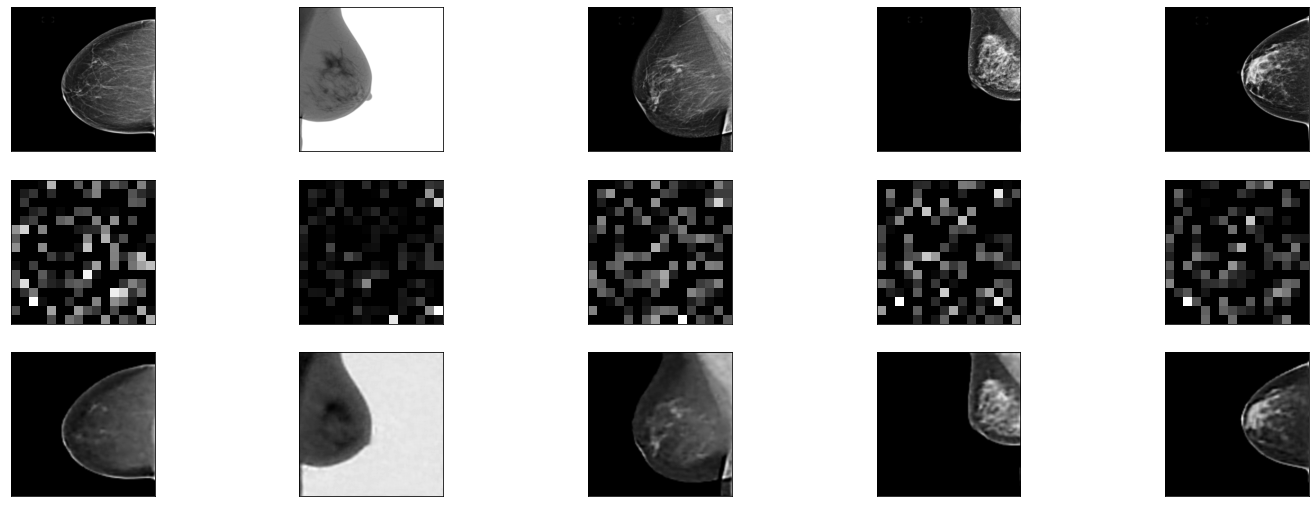

In [13]:
with torch.no_grad():
    for i in range(len(code_sides)):
        number = 5
        plt.figure(figsize=(25, 9))
        for index in range(number):
            # display original
            ax = plt.subplot(3, number, index + 1)
            test_examples = test_example_sets[i]
            copyback = test_examples[index].cpu()
            plt.imshow(copyback.numpy().reshape(height, width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display codes
            ax = plt.subplot(3, number, index + 1 + number)
            codes = code_sets[i]
            code_copyback = codes[index].cpu()
            plt.imshow(code_copyback.numpy().reshape(code_sides[i],code_sides[i]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, number, index + 6 + number)
            reconstruction = reconstruction_sets[i]
            recon_copyback = reconstruction[index].cpu()
            plt.imshow(recon_copyback.numpy().reshape(height, width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        out_path = "output"+str(i)+".png" 
        plt.savefig(out_path)
        plt.show()